## **М19-ИВТ3**
## **Тотменина Елена**
## **Сеть - вариант 1**
## **Датасет - вариант 1**

### Подготовка: монтирование диска, загрузка и импорт модулей

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install idx2numpy
import idx2numpy
!pip install python-mnist
from mnist import MNIST

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import sys
import os
from PIL import ImageFile

  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-cp36-none-any.whl size=7905 sha256=1c9d5622d886cb60fe85d06b2f17bc48f281da5fd8d48fa40f1542e1a1584cd6
  Stored in directory: /root/.cache/pip/wheels/7a/c1/da/284ce80a748fab898b8d1fa95468a386e7cf3b81da18511f9d
Successfully built idx2numpy


### Распаковка файлов

In [ ]:
# !unzip -uq "/content/drive/My Drive/Colab Notebooks/mnist-data-zip/train-labels-idx1-ubyte.zip" -d "/content/drive/My Drive/Colab Notebooks/mnist-data"
# !unzip -uq "/content/drive/My Drive/Colab Notebooks/mnist-data-zip/train-images-idx3-ubyte.zip" -d "/content/drive/My Drive/Colab Notebooks/mnist-data"
# !unzip -uq "/content/drive/My Drive/Colab Notebooks/mnist-data-zip/t10k-labels-idx1-ubyte.zip" -d "/content/drive/My Drive/Colab Notebooks/mnist-data"
# !unzip -uq "/content/drive/My Drive/Colab Notebooks/mnist-data-zip/t10k-images-idx3-ubyte.zip" -d "/content/drive/My Drive/Colab Notebooks/mnist-data"

In [ ]:
mndata = MNIST("/content/drive/My Drive/Colab Notebooks/mnist-data")

# train_image, train_label = mndata.load_training()
# test_image_, test_label_ = mndata.load_testing()

### Конвертирование файлов в png из ubyte

In [ ]:
from google.colab.patches import cv2_imshow

train_image = '/content/drive/My Drive/Colab Notebooks/mnist-data/train-images-idx3-ubyte'
train_label = '/content/drive/My Drive/Colab Notebooks/mnist-data/train-labels-idx1-ubyte'
test_image = '/content/drive/My Drive/Colab Notebooks/mnist-data/t10k-images-idx3-ubyte'
test_label = '/content/drive/My Drive/Colab Notebooks/mnist-data/t10k-labels-idx1-ubyte'

train_i = idx2numpy.convert_from_file(train_image)
test_i = idx2numpy.convert_from_file(test_image)

# for i in range(2000):
#   # cv2_imshow(train_i[i])
#   cv2.imwrite(train_image+'_folder/'+str(i)+'.png', train_i[i])

# for i in range(1000):
  # cv2_imshow(test_i[i])
  # print(test_image+'_folder/'+str(test_label_[i])+'/'+str(i)+'.png')
  # cv2.imwrite(test_image+'_folder/'+str(test_label_[i])+'/'+str(i)+'.png', test_i[i])

### Основные параметры

In [ ]:
# img_width, img_height = 28, 28 
img_width, img_height = 150, 150 
input_shape = (img_width, img_height,3)
tr_ratio = .05
batch_size = 256

train_path = "/content/drive/My Drive/Colab Notebooks/mnist-data/train-images-idx3-ubyte_folder"
validation_path = "/content/drive/My Drive/Colab Notebooks/mnist-data/t10k-images-idx3-ubyte_folder"
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Подготовка Xception

In [ ]:
base_model = Xception(input_shape=(img_width, img_height, 3),
                      weights='imagenet', # Использование весов предобученных на Imagenet
                      include_top=False) # Первый слой - НЕ полносвязный 

x = base_model.output
x = GlobalAveragePooling2D()(x) # Добавляем слой в модель

nb_classes = 10 # 10 классов цифр
predictions = Dense(nb_classes, activation='softmax')(x)
model = Model(base_model.input, predictions)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

' del base_model, predictions '

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

# Генерирует батчи новых данных в реальном времени
train_gen_data = ImageDataGenerator(rescale=1. / 255, # Коэффициент масштабирования
                                    rotation_range=tr_ratio, # Диапазон градусов для вращений
                                    shear_range=tr_ratio, # Угол сдвига против часовой стрелки в градусах
                                    zoom_range=tr_ratio, # Диапазон случайного увеличения
                                    cval=tr_ratio, # Значение, используемое для точек за пределами границ
                                    horizontal_flip=False, # Произвольно переворачивает входы по горизонтали
                                    vertical_flip=False) # Произвольно переворачивает входы по вертикали

test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_gen_data.flow_from_directory(train_path,
                                                     target_size=(img_width, img_height),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

test_generator = test_data_gen.flow_from_directory(validation_path,
                                                   target_size=(img_width, img_height),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')

Found 2000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
callbacks_list = [EarlyStopping(monitor='accuracy', # Параметр, который необходимо контролировать
                                patience=4, # Количество эпох без улучшения, после которых обучение будет остановлено
                                verbose=0)
]

In [ ]:
model.compile(optimizer='nadam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Обучение модели

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    # epochs=40,
                    epochs=20,
                    validation_data=test_generator,
                    validation_steps=test_generator.n // batch_size,
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/20
7/7 [==============================] - 198s 28s/step - loss: 2.1956 - accuracy: 0.2523 - val_loss: 1.8600 - val_accuracy: 0.5078
Epoch 2/20
7/7 [==============================] - 194s 28s/step - loss: 1.6853 - accuracy: 0.5499 - val_loss: 1.4782 - val_accuracy: 0.6211
Epoch 3/20
7/7 [==============================] - 197s 28s/step - loss: 1.3520 - accuracy: 0.6714 - val_loss: 1.2263 - val_accuracy: 0.6667
Epoch 4/20
7/7 [==============================] - 192s 27s/step - loss: 1.1473 - accuracy: 0.7116 - val_loss: 1.0951 - val_accuracy: 0.6849
Epoch 5/20
7/7 [==============================] - 197s 28s/step - loss: 1.0009 - accuracy: 0.7546 - val_loss: 1.0007 - val_accuracy: 0.6927
Epoch 6/20
7/7 [==============================] - 195s 28s/step - loss: 0.9250 - accuracy: 0.7597 - val_loss: 0.9111 - val_accuracy: 0.7044
Epoch 7/20
7/7 [==============================] - 193s 28s/step - loss: 0.8731 - accuracy: 0.7632 - val_loss: 0.8855 - val_accuracy: 0.7240
Epoch 8/20
7/7 [====

In [ ]:
model.save_weights("/content/drive/My Drive/Colab Notebooks/lab2/model_weights.h5")
model.save("/content/drive/My Drive/Colab Notebooks/lab2/model_keras-1.h5")

### Графики по процессу обучения

In [ ]:
class Graph:
  def __init__(self, epochs):
    self.epochs = epochs
  def draw(self, data, data2, data_label, data2_label):
    plt.figure(figsize=(20,5))
    plt.plot(history.history[data], color = 'b', label=data_label)
    plt.plot(history.history[data2], color= 'r', label=data2_label)
    plt.legend()
    plt.show()
    plt.clf()

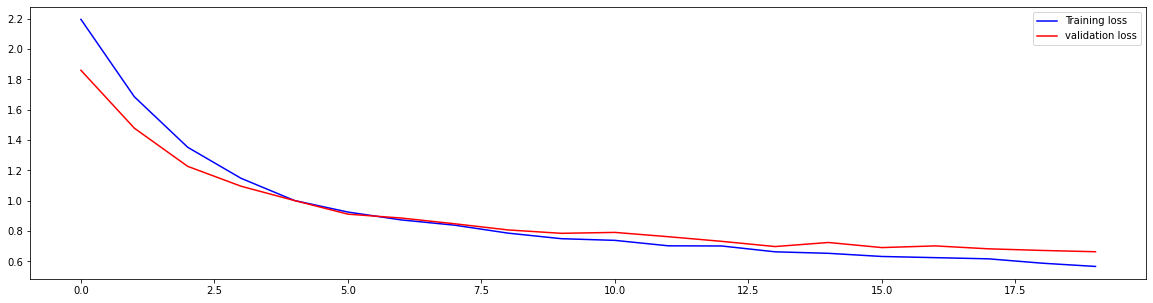

<Figure size 432x288 with 0 Axes>

In [ ]:
curve = Graph(20)
curve.draw('loss','val_loss','Training loss','validation loss')

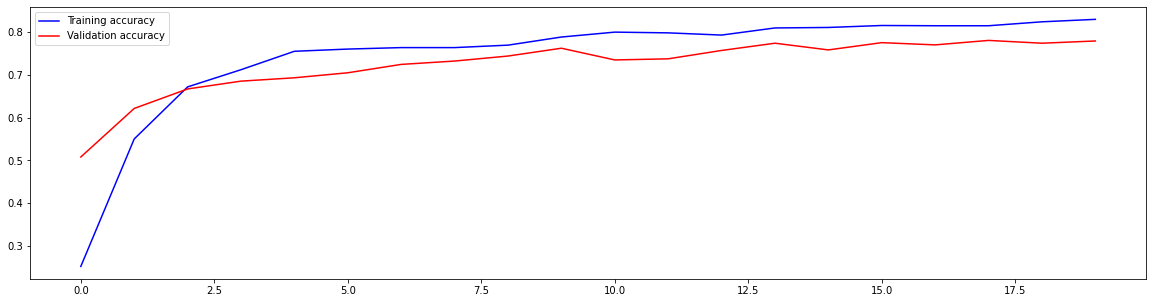

<Figure size 432x288 with 0 Axes>

In [ ]:
curve.draw('accuracy','val_accuracy',"Training accuracy","Validation accuracy")

### Предсказание на примерах

In [ ]:
import random
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from google.colab.patches import cv2_imshow
import cv2
import json

image_dirs = [
              os.path.join(train_path, '0'),
              os.path.join(train_path, '1'),
              os.path.join(train_path, '2'),
              os.path.join(train_path, '3'),
              os.path.join(train_path, '4'),
              os.path.join(train_path, '5'),
              os.path.join(train_path, '6'),
              os.path.join(train_path, '7'),
              os.path.join(train_path, '8'),
              os.path.join(train_path, '9'),
]
path_to_image = [os.path.join(dir, random.choice(os.listdir(dir))) for dir in image_dirs]
classes = ['0', 
           '1',
           '2',
           '3',
           '4',
           '5',
           '6',
           '7',
           '8',
           '9',]

for path in path_to_image:
  out = model.predict(np.expand_dims(img_to_array(load_img(path)), axis=0) / 255.)[0]
  img = cv2.imread(path)
  cv2.putText(img, (str(max(out))), (40,40),
      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
  cv2_imshow(img)
  print(dict(zip(classes,[round(x, 2) for x in out])), path.split('/')[-1])

{'0': 0.1, '1': 0.1, '2': 0.1, '3': 0.1, '4': 0.11, '5': 0.1, '6': 0.1, '7': 0.1, '8': 0.1, '9': 0.1} 1930.png


{'0': 0.08, '1': 0.11, '2': 0.12, '3': 0.09, '4': 0.1, '5': 0.09, '6': 0.08, '7': 0.12, '8': 0.11, '9': 0.1} 604.png


{'0': 0.1, '1': 0.1, '2': 0.1, '3': 0.1, '4': 0.11, '5': 0.1, '6': 0.1, '7': 0.1, '8': 0.1, '9': 0.1} 365.png


{'0': 0.1, '1': 0.1, '2': 0.1, '3': 0.1, '4': 0.1, '5': 0.1, '6': 0.1, '7': 0.1, '8': 0.1, '9': 0.1} 1428.png


{'0': 0.1, '1': 0.1, '2': 0.11, '3': 0.09, '4': 0.1, '5': 0.1, '6': 0.1, '7': 0.1, '8': 0.1, '9': 0.1} 1576.png


{'0': 0.1, '1': 0.1, '2': 0.1, '3': 0.1, '4': 0.1, '5': 0.1, '6': 0.09, '7': 0.11, '8': 0.11, '9': 0.1} 1433.png


{'0': 0.1, '1': 0.1, '2': 0.1, '3': 0.1, '4': 0.1, '5': 0.1, '6': 0.1, '7': 0.1, '8': 0.1, '9': 0.1} 1092.png


{'0': 0.1, '1': 0.1, '2': 0.1, '3': 0.1, '4': 0.1, '5': 0.1, '6': 0.1, '7': 0.1, '8': 0.1, '9': 0.1} 371.png


{'0': 0.1, '1': 0.1, '2': 0.1, '3': 0.1, '4': 0.11, '5': 0.1, '6': 0.1, '7': 0.1, '8': 0.1, '9': 0.1} 439.png


{'0': 0.1, '1': 0.1, '2': 0.1, '3': 0.09, '4': 0.1, '5': 0.1, '6': 0.1, '7': 0.11, '8': 0.11, '9': 0.1} 1850.png


### Добавление шума на изображения

In [ ]:
def get_normal_noise(image):
  noise = np.random.normal(128, 20, (image.shape[0], image.shape[1]))
  return np.dstack((noise, noise, noise)).astype(np.uint8)

def get_uniform_noise(image):
  noise = np.random.uniform(0, 255, (image.shape[0], image.shape[1]))
  return np.dstack((noise, noise, noise)).astype(np.uint8)

def set_normal_noise(image):
  noise = get_normal_noise(image)
  noise_image = cv2.add(image.astype(np.float64), noise.astype(np.float64))
  cv2.normalize(noise_image, noise_image, 0, 255, cv2.NORM_MINMAX)
  return noise_image

def set_uniform_noise(image):
  noise = get_uniform_noise(image) 
  noise_image = cv2.add(image.astype(np.float64), noise.astype(np.float64))
  cv2.normalize(noise_image, noise_image, 0, 255, cv2.NORM_MINMAX)
  return noise_image

In [ ]:
gen_with_normal_noise = ImageDataGenerator(rescale=1./255, 
                                           preprocessing_function=set_normal_noise).flow_from_directory(validation_path,
                                                                                                        target_size=(img_width, img_height),
                                                                                                        batch_size=batch_size,
)

gen_with_uniform_noise = ImageDataGenerator(rescale=1./255, 
                                            preprocessing_function=set_uniform_noise).flow_from_directory(validation_path,
                                                                                                          target_size=(img_width, img_height),
                                                                                                          batch_size=batch_size,
)

Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [ ]:
# Добавление нормального шума
for i, path in zip(list(range(0, 9, 3)),[os.path.join(dir, random.choice(os.listdir(dir))) for dir in image_dirs]):
  image = cv2.resize(cv2.imread(path), (250, 250))
  cv2_imshow(np.concatenate((image, get_normal_noise(image), set_normal_noise(image)), axis=1))
# Добавление равномерного шума
for i, path in zip(list(range(0, 9, 3)),[os.path.join(dir, random.choice(os.listdir(dir))) for dir in image_dirs]):
  image = cv2.resize(cv2.imread(path), (250, 250))
  cv2_imshow(np.concatenate((image, get_uniform_noise(image), set_uniform_noise(image)), axis=1))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
loss, accuracy = model.evaluate(gen_with_normal_noise)
loss, accuracy = model.evaluate(gen_with_uniform_noise)

4/4 [==============================] - 61s 15s/step - loss: 2.0412 - accuracy: 0.3210


### Карта признаков

In [ ]:
def drawFeatureMap(model_t, image_tensor):
  blocks = []

  for i, layer in enumerate(model_t.layers):
    if 'conv' in layer.name and not '_conv' in layer.name:
        blocks.append(i + 2)
        
  for layer_index in blocks:
    model_f = keras.models.Model(inputs=model_t.inputs, 
                              outputs=model_t.layers[layer_index].output)
    
    feature_maps = model_f.predict(image_tensor)
    plt.figure(figsize=[64, 64])
    for i, feature_map in enumerate([feature_maps[0, :, :, j] for j in range(feature_maps.shape[-1])]):
      plt.subplot(40, 40, i+1, xticks=([]), yticks=([]))
      plt.imshow(feature_map, cmap='gray')
    plt.show()

In [ ]:
import keras 

image_path = '/content/drive/My Drive/Colab Notebooks/mnist-data/t10k-images-idx3-ubyte_folder/0/3.png'
image = load_img(image_path)
tensor = np.expand_dims(img_to_array(image), axis=0) / 255.
plt.imshow(image)

drawFeatureMap(model, tensor)

Output hidden; open in https://colab.research.google.com to view.